This notebook was designed to work with [Google Colab](https://colab.research.google.com/github/lokdoesdata/syracuse-assorted/blob/main/ist_652/homework_1/lok_ngan_homework_1.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lokdoesdata/syracuse-assorted/blob/main/ist_652/homework_1/lok_ngan_homework_1.ipynb)

# IST 652 - Homework 1: Structured Data
Lok Ngan

Due: May 7, 2021

-------------
In this exercise, a small dataset containing donor data would be used to illustrate some fundamental techniques in data mainpulation and visualization using Python.  

## Set Up

For this exercise, popular Python packages [`pandas`](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html), [`matplotlib`](https://matplotlib.org/stable/users/installing.html), and [`seaborn`](https://seaborn.pydata.org/installing.html) were used.  Additionally, `pathlib` was used for I/O.

* `Pandas` is a popular data manipulation package.  
* `Matplotlib` is a graphical library that can be used to create static, animated or interactive visuals.
* `Seaborn` is a graphical library built on top of `matplotlib`.
* `Pathlib` is used to handles I/O.

Additionally, [`sklearn`](https://scikit-learn.org/stable/install.html), [`lightgbm`](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html), and [`shap`](https://shap.readthedocs.io/en/latest/index.html) would be used for more advanced visualization.

### Install LightGBM and SHAP onto Google Colab

In [ ]:
%pip install lightgbm
%pip install shap

### Import packages

In [26]:
# Base Python
from pathlib import Path

# Additional packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

## I/O

The data is moved to Github.  An output folder would be created in the current working directory if one does not exist.

In [2]:
# set up data path; path is from Github
DATA_PATH = r'https://raw.githubusercontent.com/lokdoesdata/syracuse-assorted/main/ist_652/homework_1/data/donors_data.csv'

In [3]:
# create output folder
OUTPUT_PATH = Path.cwd().joinpath('output')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

## Data

The dataset used in this exercise is a list of donors.

In [4]:
df = pd.read_csv(DATA_PATH, index_col = 0)

There are 3,120 rows across 23 columns in this dataset

In [5]:
df.shape

(3120, 23)


| Column Header   | Description                                             |
| :-------------- | :------------------------------------------------------ |
| Row Id.         | ID Number                                               |
| zipconvert_2    | Region 2 (Onehot encoded)                               |
| zipconvert_3    | Region 3 (Onehot encoded)                               |
| zipconvert_4    | Region 4 (Onehot encoded)                               |
| zipconvert_5    | Region 5 (Onehot encoded)                               |
| homeowner dummy | Is homeowner?                                           |
| NUMCHLD         | Number of Children                                      |
| INCOME          | Household income                                        |
| gender dummy    | Gender (0 = Male, 1 = Female)                           |
| WEALTH          | Wealth rating (9 is highest, 0 is lowest)               |
| HV              | Median Home Value of Potential Donor's neighborhood     |
| Icmed           | Median Family Income of Potential Donor's neighborhood  |
| Icavg           | Average Family Income of Potential Donor's neighborhood |
| IC15            | Percent "Low Income" of Potential Donor's neighborhood  |
| NUMPROM         | Lifetime number of promotions received                  |
| RAMNTALL        | Dollar amount of lifetime gifts to date                 |
| MAXRAMNT        | Dollar amount of largest gift to date                   |
| LASTGIFT        | Dollar amount of most recent gift                       |
| totalmonths     | Number of months since last donation                    |
| TIMELAG         | Number of months between first and second gift          |
| AVGGIFT         | Average dollar amount of gifts to date                  |
| TARGET_B        | Is Donor?                                               |
| TARGET_D        | Donation Amount                                         |

### Type of data

Every column in this dataset was already encoded to a numerical value.

In [6]:
df.dtypes

Row Id.              int64
zipconvert_2         int64
zipconvert_3         int64
zipconvert_4         int64
zipconvert_5         int64
homeowner dummy      int64
NUMCHLD              int64
INCOME               int64
gender dummy         int64
WEALTH               int64
HV                   int64
Icmed                int64
Icavg                int64
IC15                 int64
NUMPROM              int64
RAMNTALL           float64
MAXRAMNT           float64
LASTGIFT           float64
totalmonths          int64
TIMELAG              int64
AVGGIFT            float64
TARGET_B             int64
TARGET_D           float64
dtype: object

### Decoding the ZIP Code

The ZIP code columns are one-hot encoded in the source file, decoding it back to label encoded to streamline some visualizations

In [7]:
def zip_code_decoder(two, three, four, five):
    if two:
        return(2)
    elif three:
        return(3)
    elif four:
        return(4)
    elif five:
        return(5)
    else:
        return(1)

df['ZIP Code Area'] = df[['zipconvert_2', 'zipconvert_3', 'zipconvert_4', 'zipconvert_5']].apply(lambda x: zip_code_decoder(*x), axis=1)

### Dropping columns

The column removed are:
* Row ID
* ZIP Code 2, 3, 4, and 5
* Donated Amount

In [8]:
df.drop(['Row Id.', 'zipconvert_2', 'zipconvert_3', 'zipconvert_4', 'zipconvert_5', 'TARGET_D'], axis=1, inplace=True)

### Renaming Columns for Human

In [28]:
df.rename({
    'homeowner dummy': 'Homeowner',
    'NUMCHLD': 'Number of Children',
    'INCOME': 'Income',
    'gender dummy': 'Gender',
    'WEALTH': 'Wealth',
    'HV': 'Home Value',
    'Icmed': 'Neighborhood Median Income',
    'Icavg': 'Neighborhood Mean Income',
    'IC15': 'Neighborhood Low Income Percentage',
    'NUMPROM': 'Number of Promotions',
    'RAMNTALL': 'Total Donation Amount',
    'MAXRAMNT': 'Highest Donation Amount',
    'LASTGIFT': 'Last Donation Amount',
    'totalmonths': 'Months Since Last Donation',
    'TIMELAG': 'Months Between First and Second Donation',
    'AVGGIFT': 'Average Donation Amount',
    'TARGET_B': 'Donated' 
}, axis=1, inplace=True)

### Are there any strange columns?

Wealth distribution looks very uneven in this dataset.  Perhaps it's something to evaluate.

In [29]:
df.Wealth.value_counts()

8    1700
9     189
5     186
7     180
6     162
3     162
4     153
2     138
1     138
0     112
Name: Wealth, dtype: int64

## Exploratory Data Analysis

### How are each feature correlated to each other?

As expected, an increase in median income correlated to an increase in mean income.  Also expected, the increase in median or mean income correlated to the decrease of low income percentage.

One interesting correlation was between last donation amount and average donation amount.  They are negatively correlated.  It implies that the average donation amount for the donor tends to be higher, if the last donation amount is lower, or vice versa.  This is contrary to

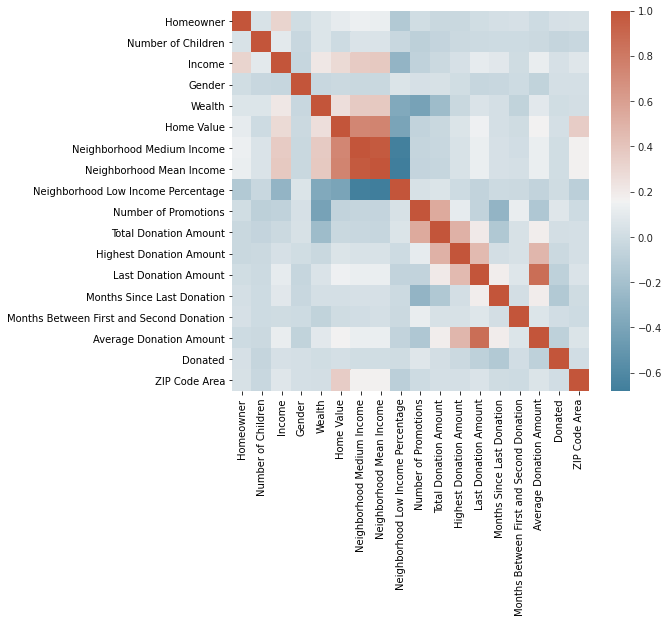

In [30]:
f1, ax1 = plt.subplots(1, figsize=(8,7))
df_corr = df.corr()

with sns.axes_style('white'):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    g1 = sns.heatmap(data=df_corr, cmap=cmap, ax=ax1)

f1.savefig(OUTPUT_PATH.joinpath('correlation_matrix.png'), dpi=200, bbox_inches='tight')

### Are wealth distributed (Gini Coefficient) evenly in each of the ZIP Code Area?

ZIP Code 1 has the highest level of wealth inequality (Gini) and the lowest median income.

In [31]:
def gini(x):
    # https://en.wikipedia.org/wiki/Mean_absolute_difference#Relative_mean_absolute_difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad/np.mean(x)
    gini = 0.5 * rmad
    return(gini)

In [32]:
gini = df.groupby('ZIP Code Area')['Wealth'].apply(lambda x: gini(x.values))
income = df.groupby('ZIP Code Area')['Income'].mean()
df_income_gini = pd.concat([income, gini], axis=1)

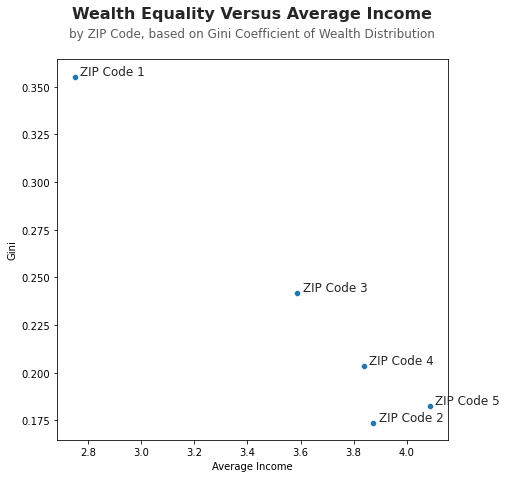

In [33]:
f2, ax2 = plt.subplots(1, figsize=(7,7))

with sns.axes_style('white'):
    sns.despine(f1)
    g2 = sns.scatterplot(data=df_income_gini, x='Income', y='Wealth', ax=ax2)

    ax2.text(x=0.5, y=1.1, s='Wealth Equality Versus Average Income', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax2.transAxes)
    ax2.text(x=0.5, y=1.05, s='by ZIP Code, based on Gini Coefficient of Wealth Distribution', fontsize=12, alpha=0.75, ha='center', va='bottom', transform=ax2.transAxes)

    for i, row in df_income_gini.iterrows():
        ax2.text(x=row['Income']+0.02, y=row['Wealth']+0.001, s=f'ZIP Code {i}', fontsize=12)
    
    ax2.set_ylabel('Gini')
    ax2.set_xlabel('Average Income')

f2.savefig(OUTPUT_PATH.joinpath('wealth_vs_income.png'), dpi=200, bbox_inches='tight')

### What Factors Drive People to Donate?

In order to determine what factors drive people to donate, a model was created with [lightGBM](https://lightgbm.readthedocs.io/en/latest/index.html) and intepreted using [SHAP](https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf).

The importance of individual features are shown below with the most importance at the top.

A few observations:
* Highest donation amount is a strong feature in determining if someone is going to donate. If the highest donation amount is small, the person tends to donate.
* Months since last donation is another strong feature.  People are less likely to donate if they hadn't donated in a while.
* Income is the third strongest feature.  People with higher income tends to donate.
* Gender, zip code, number of children, and homeownership have little to no impact on determining if someone will donate.

In [34]:
X = df.drop(['Donated'], axis=1)
y = df['Donated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=652)
lgb_train= lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

In [35]:
params = {
    'max_bin': 512,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.05,
    'metric': 'binary_logloss',
    'num_leaves': 10,
    'verbose': -1,
    'min_data': 100
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_test], early_stopping_rounds=50, verbose_eval=-1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.68114


In [36]:
shap_values = shap.TreeExplainer(model).shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [37]:
df_shap_values = pd.DataFrame(shap_values[1], columns = X.columns)

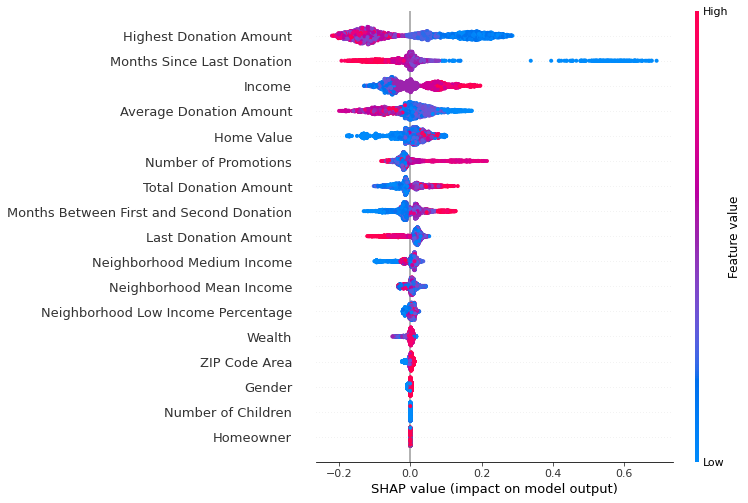

In [38]:
shap.summary_plot(shap_values[1], X.astype('float'), show=False)
plt.savefig(OUTPUT_PATH.joinpath('shap.png'), dpi=200, bbox_inches='tight')

## Output

In [39]:
with pd.ExcelWriter(OUTPUT_PATH.joinpath('lok_ngan_homework_1_output.xlsx')) as writer:
    df_corr.to_excel(writer, sheet_name='Correlation Matrix')
    df_income_gini.to_excel(writer, sheet_name='Income_vs_Gini')
    df_shap_values.to_excel(writer, sheet_name='Shap Values')

The output files from this notebook can be found [here](https://github.com/lokdoesdata/syracuse-assorted/tree/main/ist_652/homework_1/output)
